In [61]:
# REMOVING HAZE FROM MULTIPLE IMAGES AND SAVING THEM INTO ANOTHER FOLDER 

import keras
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import cv2
from os import listdir,makedirs
from os.path import isfile,join
import tensorflow as tf
import numpy as np
import glob
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage


In [62]:
def bgr2rgb(img):
    b,g,r = cv.split(img)
    return cv.merge([r,g,b])

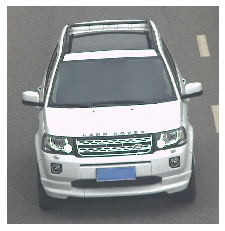

In [63]:
#Here is a sample of a hazed image that we would be working with. 
#The haze faintly obscures the foreground. We want to recover the unhazed image.
img = bgr2rgb(cv.imread("C:/Users/PC/Desktop/New Dataset/2.jpg"))
plt.imshow(img)
plt.axis("off");

In [64]:
def get_dark_channel_prior(img, w_size=15):
    """
    img    -> 3D tensor in RGB format
    w_size -> size of patch to consider (default is 15)
    """    
    J_dark = ndimage.minimum_filter(img, footprint=np.ones((w_size,w_size,3)), mode='nearest')
            
    return J_dark[:,:,1]

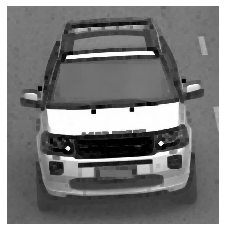

In [65]:
tian_jdark = get_dark_channel_prior(img)
plt.imshow(tian_jdark, cmap='gray')
plt.axis('off');

In [66]:
def estimate_atmospheric_light(img, w_size=15):
    """
    img -> 3D tensor in RGB format
    
    ret -> 
        A_r |
        A_g | -> estimated atmospheric light in the RGB channels
        A_c |
    """
    size = img.shape[:2]
    k = int(0.001*np.prod(size))
    j_dark = get_dark_channel_prior(img, w_size=w_size)
    idx = np.argpartition(-j_dark.ravel(),k)[:k]
    x, y = np.hsplit(np.column_stack(np.unravel_index(idx, size)), 2)
    
    A = np.array([img[x,y,0].max(), img[x,y,1].max(), img[x,y,2].max()])
    return A

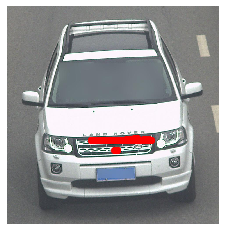

In [67]:
size = img.shape[:2]
k = int(0.001*np.prod(size))
idx = np.argpartition(-tian_jdark.ravel(),k)[:k]
zz = np.column_stack(np.unravel_index(idx, tian_jdark.shape))
x, y = np.hsplit(zz,2)
plt.imshow(img)
plt.scatter(y, x, c='r')
plt.axis('off')
plt.show();

In [68]:
def estimate_transmission(img, omega=0.95, w_size=15):
    """
    Estimates the transmission map using the dark channel prior of the normalized image. 
    A small fraction, omega, of the haze is kept to retain depth perspective after haze removal.
    
    img   -> 3D Tensor in RGB format
    omega -> fraction of haze to keep in image (default is 0.95)
    """
    A= estimate_atmospheric_light(img)
    norm_img = img / A
    norm_img_dc = get_dark_channel_prior(norm_img, w_size=w_size)

    return 1 - omega*norm_img_dc

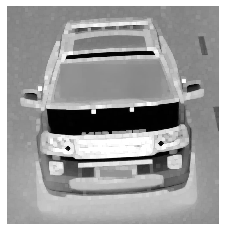

In [69]:
alpha_map = estimate_transmission(img)
plt.imshow(alpha_map, cmap='gray')
plt.axis("off");

In [70]:
def guided_filter(I, p, omega=60, eps=0.01):
    """
    from http://kaiminghe.com/publications/eccv10guidedfilter.pdf
    and  https://arxiv.org/pdf/1505.00996.pdf
    
    I     -> guidance image, 3D Tensor in RGB format
    p     -> filtering input image, 
    omega -> window size (default is 60)
    eps   -> regularization parameter (default 0.01)
    """
    
    w_size = (omega,omega)
    I = I/255
    I_r, I_g, I_b = I[:,:,0], I[:,:,1], I[:,:,2]
    
    mean_I_r = cv.blur(I_r, w_size)
    mean_I_g = cv.blur(I_g, w_size)
    mean_I_b = cv.blur(I_b, w_size)
    
    mean_p = cv.blur(p, w_size)
    
    mean_Ip_r = cv.blur(I_r*p, w_size)
    mean_Ip_g = cv.blur(I_g*p, w_size)
    mean_Ip_b = cv.blur(I_b*p, w_size)
         
    cov_Ip_r =  mean_Ip_r - mean_I_r*mean_p
    cov_Ip_g =  mean_Ip_g - mean_I_g*mean_p
    cov_Ip_b =  mean_Ip_b - mean_I_b*mean_p
    cov_Ip = np.stack([cov_Ip_r, cov_Ip_g, cov_Ip_b], axis=-1)
    
    var_I_rr = cv.blur(I_r*I_r, w_size) - mean_I_r*mean_I_r
    var_I_rg = cv.blur(I_r*I_g, w_size) - mean_I_r*mean_I_g
    var_I_rb = cv.blur(I_r*I_b, w_size) - mean_I_r*mean_I_b
    var_I_gb = cv.blur(I_g*I_b, w_size) - mean_I_g*mean_I_b
    var_I_gg = cv.blur(I_g*I_g, w_size) - mean_I_g*mean_I_g
    var_I_bb = cv.blur(I_b*I_b, w_size) - mean_I_b*mean_I_b
    
    a = np.zeros(I.shape)
    for x, y in np.ndindex(I.shape[:2]):
        Sigma = np.array([
            [var_I_rr[x,y], var_I_rg[x,y], var_I_rb[x,y]],
            [var_I_rg[x,y], var_I_gg[x,y], var_I_gb[x,y]],
            [var_I_rb[x,y], var_I_gb[x,y], var_I_bb[x,y]]
        ])
        c = cov_Ip[x,y,:]
        
        a[x,y,:] = np.linalg.inv(Sigma + eps*np.eye(3)).dot(c)
        
    mean_a = np.stack([cv.blur(a[:,:,0], w_size), cv.blur(a[:,:,1], w_size), cv.blur(a[:,:,2], w_size)], axis=-1)
    mean_I = np.stack([mean_I_r, mean_I_g, mean_I_b], axis=-1)
    
    b = mean_p - np.sum(a*mean_I, axis=2)
    mean_b = cv.blur(b, w_size)
    q = np.sum(mean_a*I, axis=2) + mean_b
    
    return q

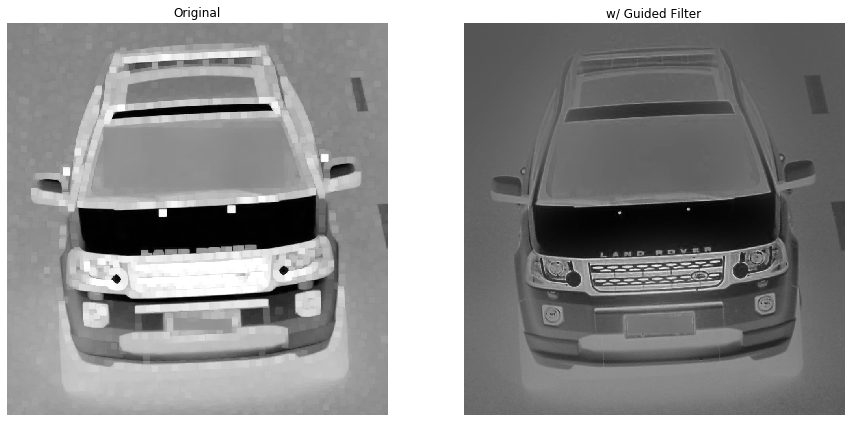

In [71]:
f_alpha_map = guided_filter(img, alpha_map, omega=200, eps=1e-3)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))

ax1.imshow(alpha_map, cmap="gray")
ax1.set_title("Original")
ax1.axis('off')

ax2.imshow(f_alpha_map, cmap="gray")
ax2.set_title("w/ Guided Filter")
ax2.axis('off');

In [72]:

def haze_removal(img, w_size=15, a_omega=0.95, gf_w_size=200, eps=1e-6):
    """
    Implements the haze removal pipeline from 
    Single Image Haze Removal Using Dark Channel Prior by He et al. (2009)
    
    I       -> 3D tensor in RGB format
    w_size  -> window size of local patch (default is 15)
    a_omega -> fraction of haze to keep in image (default is 0.95)
    omega   -> window size for guided filter (default is 200)
    eps     -> regularization parameter for guided filter(default 1e-6)
    """
    img = img.astype(np.int16)
    A = estimate_atmospheric_light(img, w_size=w_size)
    alpha_map = estimate_transmission(img, omega=a_omega, w_size=w_size)
    f_alpha_map = guided_filter(img, alpha_map, omega=gf_w_size, eps=eps)
    
    img[:,:,0] -= A[0]
    img[:,:,1] -= A[1]
    img[:,:,2] -= A[2]
    z = np.maximum(f_alpha_map, 0.1)
    img[:,:,0] = img[:,:,0]/z
    img[:,:,1] = img[:,:,1]/z
    img[:,:,2] = img[:,:,2]/z

    img[:,:,0] += A[0]
    img[:,:,1] += A[1]
    img[:,:,2] += A[2]

    img = np.maximum(img, 0)
    img = np.minimum(img, 255)
    
    return img, f_alpha_map

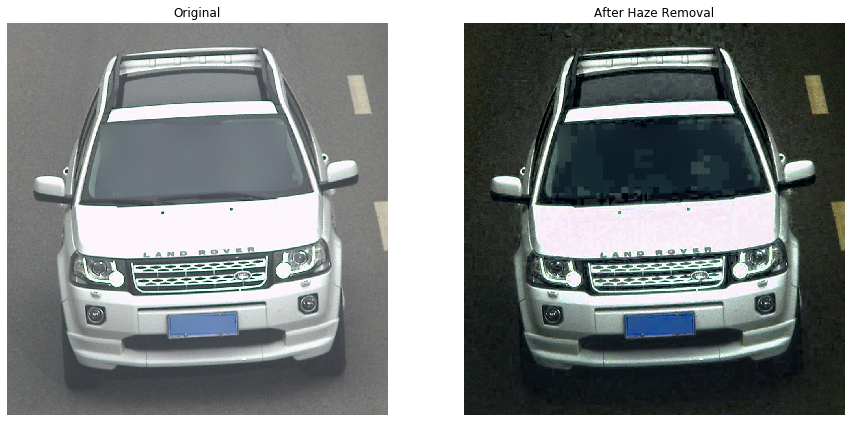

In [73]:
l, _ = haze_removal(img, w_size=15, a_omega=0.95, gf_w_size=200, eps=1e-6)
#L = haze_removal(img, w_size=15, a_omega=0.95, gf_w_size=200, eps=1e-6)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))

ax1.imshow(img)
ax1.set_title("Original")
ax1.axis('off')

ax2.imshow(l)
ax2.set_title("After Haze Removal")
ax2.axis('off');

In [108]:
path_1 = 'C:/Users/PC/Desktop/New Dataset/rgb Images/20'
paths_list = [path_1]
dstpath = 'C:/Users/PC/Desktop/New Dataset/Haze Free Images/Dehaze Images/20'
for path in paths_list:
    files = [f for f in listdir(path) if isfile(join(path,f))]
for image in files:
    try:
        img = bgr2rgb(cv.imread(os.path.join(path, image)))    
        dehazed, f_alpha_map = haze_removal(img)
        #img = cv2.imread(os.path.join(path, image))
        dstPath = join(dstpath, image)
        cv2.imwrite(dstPath, dehazed)
    except:
        print ("{} is not converted".format(image))

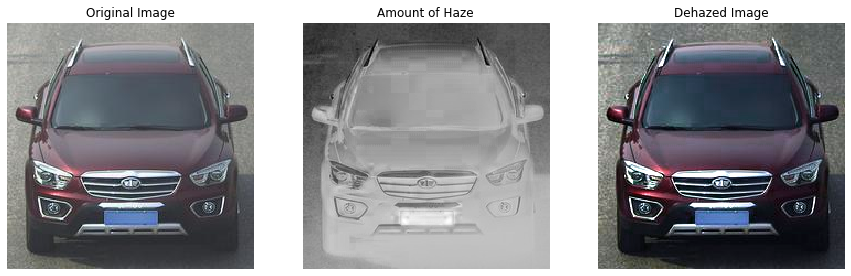

In [109]:
import glob, os

for idx, file in enumerate(glob.glob("C:/Users/PC/Desktop/New Dataset/rgb Images/A/c1.jpg")):
    img = bgr2rgb(cv.imread(file))    
    dehazed, f_alpha_map = haze_removal(img)
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,15))
    ax1.imshow(img)
    ax1.set_title("Original Image")
    ax1.axis("off")
    ax2.imshow(f_alpha_map, cmap="gray")
    ax2.set_title("Amount of Haze")
    ax2.axis("off")
    ax3.imshow(dehazed)
    ax3.set_title("Dehazed Image")
    ax3.axis("off")
    plt.show()
    
#cv2.imwrite('C:/Users/PC/Desktop/New Dataset/Haze Free Images/A/dehaze{}.jpg', f_alpha_map)
#cv2.imwrite('C:/Users/PC/Desktop/New Dataset/Haze Free Images/A/dehaze{}.jpg', dehazed)
    
    